# Update - Download New Daily OISSTv2 Data

This is foundational step towards continuous integration. 

In this notebook we use Beautifulsoup to ping the url for the most recently available OISST data, and join it with the rest of the data for the current year. This works in a way to replace preliminary data as finalized data becomes available while keeping our data current. Preliminary data is re-downloading and replaced with finalized data, and the most recent OISST data (including prelim files) is exported to be used for the remaining workflows. This step is the primer for any subsequent `Update`  workflow steps.

In [5]:
# Libraries
from bs4 import BeautifulSoup
import requests
import os
import xarray as xr
import datetime


# Set the workspace - local/ docker
workspace = "local"

# Root paths
root_locations = {"local"  : "/Users/akemberling/Box/",
                  "docker" : "/home/jovyan/"}

# Set root
box_root = root_locations[workspace]


# What Months are we checking?
now = datetime.datetime.now()
# this_month = str(now.month).rjust(2, "0")
# last_month = str(now.month - 1 if now.month > 1 else 12).rjust(2, "0")
this_month = "02"
last_month = "01"



# What was last worked on:
print(f"Working via {workspace} directory at: {box_root}")
print(f"Last update on: {now.strftime('%Y-%m-%d')}")
print(f"Data Checked for months: {last_month}-{this_month}")

Working via local directory at: /Users/akemberling/Box/
Last update on: 2021-03-01
Data Checked for months: 01-02


# Set Destinations for Downloads and Updated Files

In this section we specify what year we are interested in, and where we want the daily netcdf files to be downloaded to. I also set up a dictionary for quick-access to other resources.

In [6]:
# Update year to search for among links
update_yr = "2021"

# Out Destination - Cache gobals
_cache_root = f"{box_root}RES_Data/OISST/oisst_mainstays/"

# Cache Subdirectory Locations
cache_locs = {
  "annual_obs"        : f"{_cache_root}annual_observations/",
  "month1_cache"      : f"{_cache_root}update_caches/{this_month}/",
  "month2_cache"      : f"{_cache_root}update_caches/{last_month}/",
}

# Set the output location for where things should save to:
month1_cache = cache_locs["month1_cache"]   # Where daily caches should go for the current month
month2_cache = cache_locs["month2_cache"]   # Where daily caches should go for the last month
annual_loc   = cache_locs["annual_obs"]     # Where the complete year files live

# Print paths to validate
print("Output folder for last month's daily caches:    " + month2_cache)
print("Output folder for this month's daily caches:    " + month1_cache)
print("Access folder for yearly aggregates:            " + annual_loc)

Output folder for last month's daily caches:    /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/update_caches/01/
Output folder for this month's daily caches:    /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/update_caches/02/
Access folder for yearly aggregates:            /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/annual_observations/


### Identify the Root url for Web Scraping

This part is where we identify the web pages where the files and their directories can be accessed. `update_yr` and `update_month` are use to navigate to the right folders for updating the correct files.

In [7]:
# Root url where the yearly files are stored

# This url does not work as it is the return for a data query. When using bs4 it scrapes the site prior to the search
# https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html


# This URL is from Eric Bridgers repo oisst-clim-daily. Use the url from Eric's Repo, thank you Eric

# This URL will grab the desired update month - need to add functionality for the transition to new months
fetch_url      = f"https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/{update_yr}{this_month}/"
last_month_url = f"https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/{update_yr}{last_month}/"
print(f"Link for this month: {fetch_url}")
print(f"Link for last month: {last_month_url}")

Link for this month: https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/202102/
Link for last month: https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/202101/


### Open the http directory listing

In [8]:
####  Current Month
# open the http directory listing.
req = requests.get(fetch_url)

# Print error message if link does not work
if req.status_code != requests.codes.ok:
    print(f"Request Error, Reason: {req.reason}")

In [9]:
####  Last Month
# open the http directory listing.
req2 = requests.get(last_month_url)

# Print error message if link does not work
if req2.status_code != requests.codes.ok:
    print(f"Last Month Request Error, Reason: {req2.reason}")

### Parse URL contents with BS

Using beautiful soup we can parse the url into its html tag components. Once parsed, the next step is to look for the correct html elements to access the files we need.

In [10]:
 # Parse the url with BS and its html parser.
soup = BeautifulSoup(req.text, 'html.parser')

# Parse last month
soup2 = BeautifulSoup(req2.text, 'html.parser')

### Files Found for Last Month:

Need to check last month to keep track with the turnover on preliminary files. After ~14 days they are replaced/removed, we want to preserve the non-preliminary files as they come in.

In [12]:
# Find all href anchors in the html text
anchors2 = soup2.find_all("a")
for link in anchors2:
    if link.get("href").endswith("nc"):
        href = link.get("href")
        #print(f"Found File: {href}")

### Current Month Files:

In [13]:
# Find all href anchors in the html text
anchors = soup.find_all("a")
for link in anchors:
    if link.get("href").endswith("nc"):
        href = link.get("href")
        #print(f"Found File: {href}")

---

# Download Netcdf's to Cache Folders

Once we have verified what daily files are available the next step is to download each of them to the cache in their current daily file format. These will then be combined together with data from previous months in the year to create a single yearly netcdf

### Previous Month

In [14]:
####  Downloading Fresh Files for Previous Month

# list to store download paths
lmonth_downloads = []

# Find all the links in fetch_url which end with ".nc"
for link in anchors2:
    
    # Find links that match update year
    if link.get('href').endswith('nc'):
        
        # Get the link(s) that have ".nc" file ending
        href = link.get('href')
        
        # Use requests to download
        req_link = last_month_url + href
        req      = requests.get(last_month_url + href)
        
        # exit on status
        if req.raise_for_status():
            exit()
        
        # Open link - cache location for previous month
        dl_path = f"{month2_cache}{href}"
        file = open(dl_path, 'wb')
        chunk_size = 17000000
        
        # Add to log
        lmonth_downloads.append(dl_path)
        
        # Process in chunks to save daily files
        for chunk in req.iter_content(chunk_size):
            file.write(chunk)
        file.close()
        print(f"Caching Daily NETCDF File: {href}")

Caching Daily NETCDF File: oisst-avhrr-v02r01.20210101.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210102.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210103.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210104.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210105.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210106.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210107.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210108.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210109.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210110.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210111.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210112.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210113.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210114.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210115.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210116.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210117.nc
Caching Daily 

###  Current Month

In [16]:
####  Downloading The Current Month

# list to store download paths
new_downloads = []

# Find all the links in fetch_url which end with ".nc"
for link in anchors:
    
    # Find links that match update year
    if link.get('href').endswith(f'.nc'):
        
        # Get the link(s) that match
        href = link.get('href')
        #print(f"Download link match: {href}")
        
        # Use requests to download
        req_link = fetch_url + href
        req = requests.get(fetch_url + href)
        if req.raise_for_status():
            exit()
        
        # Open link
        dl_path = f"{month1_cache}{href}"
        file = open(dl_path, 'wb')
        chunk_size = 17000000
        
        # Add to log
        new_downloads.append(dl_path)
        
        # Process in chunks to save daily files
        for chunk in req.iter_content(chunk_size):
            file.write(chunk)
        file.close()
        print(f"Caching Daily NETCDF File: {href}")
        

Caching Daily NETCDF File: oisst-avhrr-v02r01.20210201.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210202.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210203.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210204.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210205.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210206.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210207.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210208.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210209.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210210.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210211.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210212.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210213.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210214_preliminary.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210215_preliminary.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20210216_preliminary.nc
Caching Daily NETCDF File: oisst-avh

---

# Review the files we just accessed and cached:

Now that the daily files have been accessed and saved individually, the next step is to stack them all up and align them with the annual netcdf file. Things that need to nbe done before that happens are:
 * The removal of duplicated dates
 * The overwriting of preliminary data if available

In [17]:
# 1. Find the dates with preliminary data, flag them
#

# CHANGE:
# should look for preliminary files in the cache folder and not the download list,
# this way no files slip through the cracks
# os.listdir(cache_loc)

# Check Last Month
prelim_dates2 = []
for cache_file in os.listdir(month2_cache):
    if cache_file.endswith("_preliminary.nc"): 
        start_idx = cache_file.find(f"{update_yr}{this_month}")
        end_idx = start_idx + 8
        step = int(1)
        date_id = cache_file[start_idx: end_idx: step]
        prelim_dates.append(date_id)
        
print("Last month preliminary data found for: ")
prelim_dates2

Last month preliminary data found for: 


[]

In [18]:
# Check This Month
prelim_dates = []
for cache_file in os.listdir(month1_cache):
    if cache_file.endswith("_preliminary.nc"): 
        start_idx = cache_file.find(f"{update_yr}{this_month}")
        end_idx = start_idx + 8
        step = int(1)
        date_id = cache_file[start_idx: end_idx: step]
        prelim_dates.append(date_id)
        
print("Current month preliminary data found for: ")
prelim_dates

Current month preliminary data found for: 


['20210212',
 '20210213',
 '20210214',
 '20210215',
 '20210216',
 '20210217',
 '20210218',
 '20210219',
 '20210220',
 '20210221',
 '20210222',
 '20210223',
 '20210224',
 '20210225',
 '20210226']

Once all the preliminary data files have been flagged, the next step is to check if those dates now have files without _preliminary on the end, indicating that the data has been finalized.

### Removing files that have been finalized:

If a file has both a preliminary and a finalized data it is now clear to remove the preliminary file from the folder. This frees up space and prevents it from being included in the annual file.

In [19]:
# Program to check for repeated list contents
# This code was contributed by Sandeep_anand , origins unknown
def Repeat(x): 
    _size = len(x) 
    repeated = [] 
    for i in range(_size): 
        k = i + 1
        for j in range(k, _size): 
            if x[i] == x[j] and x[i] not in repeated: 
                repeated.append(x[i]) 
    return repeated 

In [20]:
#### Check if which dates only have prelim data, or if there is also finalized data:


#### Last Month:
# list of duplicated dates, dates where we can ignore the preliminary data
finalized_dates2 = []

# check all download links for this month
for link in os.listdir(month2_cache):
    
    # check each preliminary data date
    for prelim_date in prelim_dates2:
        
        # If the date for the link matches dates with preliminary data for a link, flag the date
        if prelim_date in link:
            start_idx = link.find(f"{update_yr}{last_month}")
            end_idx = start_idx + 8
            step = int(1)
            date_id = link[start_idx: end_idx: step]
            
            # and add those to the list of dates where there is prelim and final data
            finalized_dates2.append(date_id)
            
    
# Report the dates with both preliminary and finalized data  
print("Last Month Prelim and Finalized Data Found for:")
print (Repeat(finalized_dates2))     

Last Month Prelim and Finalized Data Found for:
[]


In [21]:
####  Also check this month

# list of duplicated dates, dates where we can ignore the preliminary data
finalized_dates = []

# check all download links for this month
for link in os.listdir(month1_cache):
    
    # check each preliminary data date
    for prelim_date in prelim_dates:
        
        # If the date for the link matches dates with preliminary data for a link, flag the date
        if prelim_date in link:
            start_idx = link.find(f"{update_yr}{this_month}")
            end_idx = start_idx + 8
            step = int(1)
            date_id = link[start_idx: end_idx: step]
            
            # and add those to the list of dates where there is prelim and final data
            finalized_dates.append(date_id)
            
    
# Report the dates with both preliminary and finalized data  
print("Prelim and Finalized Data Found for:")
print (Repeat(finalized_dates))     

Prelim and Finalized Data Found for:
['20210212', '20210213']


## Remove preliminaries that have final data

If any preliminary files exist the next step is to remove them so we don't get duplicate dates when we combine the individual netcdfs

In [22]:
# Pull the dates for situations where there is both a preliminary and final file.
remove_prelim = Repeat(finalized_dates2)

# Build out the preliminary names that these would be, drop them from cache.
for repeated_date in remove_prelim:
    
    # Build full file name
    file_name = f"{month2_cache}oisst-avhrr-v02r01.{repeated_date}_preliminary.nc"
    
    # Print the ones we removed    
    print(f"File Removed for Finalized Data: {file_name}")
    
    # Remove them from the folder. Don't need them anymore.
    if os.path.exists(file_name):
        os.remove(file_name)

In [23]:
# Pull the dates for situations where there is both a preliminary and final file.
remove_prelim = Repeat(finalized_dates)

# Build out the preliminary names that these would be, drop them from cache.
for repeated_date in remove_prelim:
    
    # Build full file name
    file_name = f"{month1_cache}oisst-avhrr-v02r01.{repeated_date}_preliminary.nc"
    
    # Print the ones we removed    
    print(f"File Removed for Finalized Data: {file_name}")
    
    # Remove them from the folder. Don't need them anymore.
    if os.path.exists(file_name):
        os.remove(file_name)
    

File Removed for Finalized Data: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/update_caches/02/oisst-avhrr-v02r01.20210212_preliminary.nc
File Removed for Finalized Data: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/update_caches/02/oisst-avhrr-v02r01.20210213_preliminary.nc


---

# Building the Annual File from Caches

Now that each daily file has been checked for updates, with duplicates removed we can start gluing everything together again. First step is to load and append the most recent two months to account for any updating/finalization of files.

In [24]:
# First generate new list of filenames since removing the duplicates etc.

# List of file Names
daily_files = []


# Last Month
for file in os.listdir(f"{month2_cache}"):
    if file.endswith(".nc"):
        daily_files.append(f"{month2_cache}{file}")
        #print(f"Appending File: {file}")


# This Month
for file in os.listdir(f"{month1_cache}"):
    if file.endswith(".nc"):
        daily_files.append(f"{month1_cache}{file}")
        #print(f"Appending File: {file}")

        
# Use open_mfdataset to access all the new downloads as one file
oisst_update = xr.open_mfdataset(daily_files, combine = "by_coords")
oisst_update

,Array,Chunk
Bytes,236.39 MB,4.15 MB
Shape,"(57, 1, 720, 1440)","(1, 1, 720, 1440)"
Count,171 Tasks,57 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,236.39 MB,4.15 MB
Shape,"(57, 1, 720, 1440)","(1, 1, 720, 1440)"
Count,171 Tasks,57 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


## Do Cleanup

These new files need to be checked for duplicate dates or any strange formatting issues before joining to the other months.

In [25]:
# Get all dates where the time indexes are not (~) duplicated
oisst_noreps = oisst_update.sel(time = ~oisst_update.get_index("time").duplicated())

# Select just sst and drop Zlev coordinate from the Array
norep_sst      = oisst_noreps["sst"][:, 0, :, :].drop("zlev")
norep_sst      = xr.Dataset({"sst" : norep_sst})
update_prepped = norep_sst
update_prepped

,Array,Chunk
Bytes,236.39 MB,4.15 MB
Shape,"(57, 720, 1440)","(1, 720, 1440)"
Count,228 Tasks,57 Chunks
Type,float32,numpy.ndarray


In [76]:
# Replaced by pulling out sst as done in norep_sst

# # Drop additional coordinates and variables not in the annual file
# update_prepped = oisst_noreps
# update_prepped = update_prepped.drop_vars(["anom", "err", "ice"])
# update_prepped = update_prepped.sst.drop("zlev")
# update_prepped

In [26]:
# remove attributes, going to add back later
update_prepped.attrs = {}

---

# Next Steps:

## Load and Append to Yearly File

On the new year this will change: But currently we have an annual file of the same structure as all the others. We want to append on all the new days, avoiding any overlap/repetition.

Once that is done we just need to format everything and it can be saved out as the annual netcdf with daily increments.

In [41]:
# # tester
# tester = xr.open_dataset(f"{annual_loc}sst.day.mean.{2020}.v2.nc")
# tester

In [41]:
# Load the yearly file we're appending to
try:
    oisst = xr.open_dataset(f"{annual_loc}sst.day.mean.{update_yr}.v2.nc")
except:
    last_file = int(update_yr)-1
    oisst = xr.open_dataset(f"{annual_loc}sst.day.mean.{last_file}.v2.nc")
    oisst = oisst.drop("sst")

# What have we got
oisst

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 56)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01T12:00:00 ... 2021-02-25T12:00:00
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.5
    title:          NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surf...
    institution:    NOAA/National Centers for Environmental Information
    source:         NOAA/NCEI https://www.ncei.noaa.gov/data/sea-surface-temp...
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    version:        Version 2.1
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...

In [48]:
# Remove dates from annual file that overlap with updates.
# This will make it so the current month will overwrite as it gets finalized.


# Boolean flag for whether time is before the update_month set in beginning
def before_update(month):
    return (month < int(last_month) )

# Boolean flag for whether time is before the update_month set in beginning
def beyond_update(month):
    return (month > int(this_month) )


#####  Subset time so there isn't overlap on update month


# First - Check for any dates before
if any(oisst.time.dt.month < int(last_month)):
    
    
    print("Months after updated removed from annual file")

    # Returns the dates
    b4_update = before_update(oisst['time.month'])
    oisst_prepped = oisst.sel(time = b4_update)
    
else:
    oisst_prepped = oisst
    
    

# Next - Check for any dates beyond update
if any(oisst_prepped.time.dt.month > int(this_month)):
    
    print("Months after updated removed from annual file")

    # Returns the dates
    after_update = beyond_update(oisst_prepped['time.month'])
    oisst_prepped = oisst_prepped.sel(time = after_update)
    

    

# Output the subset
oisst_prepped

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 56)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01T12:00:00 ... 2021-02-25T12:00:00
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.5
    title:          NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surf...
    institution:    NOAA/National Centers for Environmental Information
    source:         NOAA/NCEI https://www.ncei.noaa.gov/data/sea-surface-temp...
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    version:        Version 2.1
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...

In [49]:
# append/combine updates to previous months
oisst_updated = xr.combine_by_coords(datasets = [oisst_prepped, update_prepped])
oisst_updated

,Array,Chunk
Bytes,236.39 MB,4.15 MB
Shape,"(57, 720, 1440)","(1, 720, 1440)"
Count,228 Tasks,57 Chunks
Type,float32,numpy.ndarray


## Build Netcdf Attributes

Things like the datetime origin, and the other attributes of the array should match the yearly netcdfs we have so that they can all append correctly without information loss.

In [67]:
# Take attribute information from oisst_prepped
oisst_updated.attrs = oisst_prepped.attrs
oisst_updated.attrs


#OR, make a manual addition of what they should be based on the other files, so we aren't transferring

{'Conventions': 'CF-1.5',
 'title': 'NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surface Temperature (OISST) Analysis, Version 2.1',
 'institution': 'NOAA/National Centers for Environmental Information',
 'source': 'NOAA/NCEI https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/',
 'References': 'https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2.highres.html',
 'dataset_title': 'NOAA Daily Optimum Interpolation Sea Surface Temperature',
 'version': 'Version 2.1',
 'comment': 'Reynolds, et al.(2007) Daily High-Resolution-Blended Analyses for Sea Surface Temperature (available at https://doi.org/10.1175/2007JCLI1824.1). Banzon, et al.(2016) A long-term record of blended satellite and in situ sea-surface temperature for climate monitoring, modeling and environmental studies (available at https://doi.org/10.5194/essd-8-165-2016). Huang et al. (2020) Improvements of the Daily Optimum Interpolation Sea Surface Temperature (DOISST) Ver

# Save out Annual File

Now that there is data up through the current date, and with all attributes correctly set, the annual file can be saved out.

In [69]:
# Build out destination folder:
out_folder = annual_loc
naming_structure = f"sst.day.mean.{update_yr}.v2.nc"
out_path = f"{out_folder}{naming_structure}"
out_path

'/Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/annual_observations/sst.day.mean.2021.v2.nc'

In [70]:
# close oisst and oisst_prepped
oisst.close()
oisst_prepped.close()

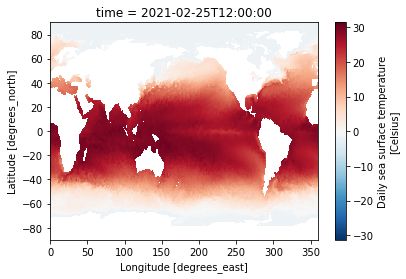

In [74]:
# # Check with a plot
oisst_updated.isel(time = -1).sst.plot()

In [75]:
# Export the finished file
oisst_updated.to_netcdf(path = out_path)
print(f"Saving / Overwriting File:    {out_path}")